In [1]:
import cv2, math, os, json, traceback, io, time
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

print(cv2.__version__)

IMAGE_DIR = '/home/johanv/nextcloud/projects/boggle2.0/cascademan/categories/5x5/images'
IMAGE_FILE = '00170.jpg'

RED = (0, 0, 255)
BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
YELLOW = (0, 255, 255)
CONTOUR_THICKNESS = 2
MAX_DISP_DIM = 500

4.5.1


In [2]:
#a generic error
class BoggleError(Exception):
    def __init__(self, arg):
        self.strerror = arg
        self.args = {arg}

def four_point_transform(image, pts, size):
    w = size
    h = size
    ntl = [0, 0]
    ntr = [w, 0]
    nbr = [w, h]
    nbl = [0, h]
    location = np.float32(pts)
    x0 = pts[0][0]
    x2 = pts[2][0]
    #make sure the board ends up rotated the correct way
    if x0 < x2:
        newLocation = np.float32([ntl, nbl, nbr, ntr])
    else:
        newLocation = np.float32([ntr, ntl, nbl, nbr])
    M = cv2.getPerspectiveTransform(location, newLocation)
    warpedimage = cv2.warpPerspective(image, M, (w, h))
    return warpedimage

def resizeWithAspectRatio(image, maxDispDim, inter=cv2.INTER_AREA):
    w = image.shape[0] #TODO width and height are swapped here
    h = image.shape[1]

    ar = w / h
    #print(ar)
    if w > h:
        nw = maxDispDim
        nh = int(maxDispDim / ar)
    elif h > w:
        nh = maxDispDim
        nw = int(maxDispDim / ar)
    else:
        nh = maxDispDim
        nw = maxDispDim

    dim = None
    (h, w) = image.shape[:2]

    r = nw / float(w)
    dim = (nw, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

def imshow_fit(name, img, maxDispDim=MAX_DISP_DIM):
    if maxDispDim is not None:
        img = resizeWithAspectRatio(img, maxDispDim)
    cv2.imshow(name, img)

def findBestCtr(contours):
    bestArea = 0
    bestCtr = None
    for i, ctr in enumerate(contours):
        area = cv2.contourArea(ctr)
        # perimeter = cv2.arcLength(ctr, True)
        if area > bestArea:
            bestArea = area
            bestCtr = ctr
    return bestCtr


def angleEveryFew(ctr, step):
    angles = []
    # dists = []
    prev = ctr[-1]
    for i in range(0, len(ctr), step):
        curr = ctr[i]
        px, py = prev[0]
        cx, cy = curr[0]
        # angle = (px-cx)/(py-cy)
        angle = math.atan2(cy - py, cx - px)
        angles.append(angle)
        # dist = math.hypot(cx-px, cy-py)
        # dists.append(dist)
        prev = curr
    return angles


def angleAvg(angles):
    x = 0
    y = 0
    for angle in angles:
        x += math.cos(angle)
        y += math.sin(angle)
    return math.atan2(y, x)


def angleDiffAbs(angle1, angle2):
    return abs(((angle1 - angle2 + math.pi) % (2 * math.pi)) - math.pi)


def runningAvg(angles, history):
    result = []
    for i in range(len(angles)):
        # avg = 0
        vals2 = []
        for j in range(history):
            val = angles[int(i + j - history / 2) % len(angles)]
            vals2.append(val)
            # avg += val
        # avg /= history
        avg = angleAvg(vals2)
        result.append(avg)
    return result


def diffAbs(vals):
    diffs = []
    prev = vals[-1]
    for i in range(0, len(vals), 1):
        curr = vals[i]
        diff = angleDiffAbs(prev, curr) * 10
        diffs.append(diff)
        prev = curr
    return diffs


def debounce(bools, history):
    result = []
    for i in range(len(bools)):
        total = 0
        for j in range(history):
            val = bools[int(i + j - history / 2) % len(bools)]
            total += val
        result.append(int(total >= history / 2))
    return result


def findGaps(diffs):
    wasGap = True
    seamI = 0
    for i, diff in enumerate(diffs):
        isGap = diff
        if not isGap and not wasGap:
            seamI = i
            break
        wasGap = isGap

    xs = range(len(diffs))
    xs = [x for x in xs]
    xs_a = xs[seamI:]
    xs_a.extend(xs[:seamI])
    diffs_a = diffs[seamI:]
    diffs_a.extend(diffs[:seamI])

    xs2 = []
    diffs2 = []
    gapsStart = []
    gapsStartY = []
    gapsEnd = []
    gapsEndY = []
    wasGap = None
    gapwidth = 0
    for x, diff in zip(xs_a, diffs_a):
        isGap = diff
        if wasGap is None:
            wasGap = isGap
        if isGap:
            xs2.append(x)
            diffs2.append(diff)
            gapwidth += 1
        if isGap and not wasGap:
            gapsStart.append(x)
            gapsStartY.append(.5)
        if not isGap and wasGap:
            gapsEnd.append(x)
            gapsEndY.append(gapwidth)
            gapwidth = 0
        wasGap = isGap
    return gapsStart, gapsStartY, gapsEnd, gapsEndY, diffs2, xs2
    # gaps = [i for i in zip(gapsStart, gapsEnd, gapsEndY)]
    # return gaps, diffs, xs2


def top4gaps(gaps):
    def length_sort(gap):
        return -gap[2]

    gaps2 = sorted(gaps, key=length_sort)
    gaps2 = gaps2[:4]
    return [i for i in gaps if i in gaps2]


def invertGaps(gaps):
    segments = []
    prev = gaps[-1]
    for curr in gaps:
        segments.append((prev[1], curr[0]))
        prev = curr
    return segments


def findSidePoints(segments, ctr, step):
    sidePoints = []
    for seg in segments:
        if seg[1] > seg[0]:
            sidePoints.append(ctr[seg[0] * step:seg[1] * step])
        else:
            sidePoints.append(ctr[seg[0] * step:, :seg[1] * step])
    return sidePoints


def getEndVals(arr, fraction):
    if fraction >= 0.5: return arr
    l = len(arr)
    keep = int(fraction * l)
    keep = max(keep, 1)
    return np.concatenate((arr[:keep], arr[l - keep:]))


def fitSidePointsToLines(sidePoints):
    lines = []
    for sp in sidePoints:
        xs = np.zeros(len(sp), int)
        ys = np.zeros(len(sp), int)
        for i, pt in enumerate(sp):
            x, y = pt[0] #TODO if pt is empty
            xs[i] = x
            ys[i] = y
        lines.append(np.polyfit(xs, ys, 1))
    return lines


def findCorners(lines):
    points = []

    prev = lines[-1]
    for curr in lines:
        a1, b1 = prev
        a2, b2 = curr

        x = (b2 - b1) / (a1 - a2)
        y = np.polyval(curr, x)
        #if math.isnan(x): x = 0 #TODO
        #if math.isnan(y): y = 0
        points.append((int(x), int(y)))
        prev = curr
    return points


def drawLinesAndPoints(image, lines, points):
    width = image.shape[1]

    for l in lines:
        y1 = int(np.polyval(l, 0))
        y2 = int(np.polyval(l, width - 1))
        cv2.line(image, (0, y1), (width - 1, y2), RED, CONTOUR_THICKNESS)

    for point in points:
        cv2.circle(image, point, 4, BLUE, 3)


def contourPlot(xs, xs2, angles, anglesAvg, diffs, diffs2, gapsStart, gapsStartY, gapsEnd, gapsEndY2, normalPlots):
    fig = plt.figure(figsize=(8,10))
    ax1 = fig.add_subplot(111)

    # ax1.scatter(xs, dists, s=10, c='b', marker="s", label="dists")
    ax1.scatter(xs, angles, s=10, c='r', marker="o", label="angles")
    ax1.scatter(xs, anglesAvg, s=10, c='b', marker="o", label="anglesAvg")
    ax1.scatter(xs, diffs, s=10, c='g', marker="o", label="diffs")
    ax1.scatter(xs2, diffs2, s=10, c='m', marker="s", label="diffs2")
    ax1.scatter(gapsStart, gapsStartY, s=10, c='c', marker="o", label="gapsStart")
    if gapsEndY2 is not None:
        ax1.scatter(gapsEnd, gapsEndY2, s=10, c='y', marker="o", label="gapsEnd")
    plt.legend(loc='best')
    if normalPlots:
        plt.show(block=False)
        return None
    else:
        return plotToImg()

def waitForKey():
    while True:
        key = cv2.waitKey(0)
        print("key", key)
        if key == 27:  # esc
            cv2.destroyAllWindows()
            quit()
        if key == ord(" ") or key == ord("q"):
            break
    cv2.destroyAllWindows()
    plt.close('all')

def waitForConsoleEnter():
    print("=== hit enter to continue ===")
    input()
    print("=== continuing ===")
    cv2.destroyAllWindows()
    plt.close('all')

#https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
#window: np.ones (flat), np.hanning, np.hamming, np.bartlett, np.blackman
def smooth(x, window_len=11, window=np.hanning):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = window(window_len)
    y = np.convolve(w / w.sum(), s, mode='valid')
    return y


def findRowsOrCols(img, doCols, smoothFactor, ax):
    smoothFactor = int(smoothFactor * img.shape[0])
    #print("smoothFactor", smoothFactor)
    
    if doCols:
        title = "colSum"
        imgSum = cv2.reduce(img, 0, cv2.REDUCE_AVG, dtype=cv2.CV_32S)
        imgSum = imgSum[0]
    else:
        #row sum
        title = "rowSum"
        imgSum = cv2.reduce(img, 1, cv2.REDUCE_AVG, dtype=cv2.CV_32S)
        imgSum = imgSum.reshape(len(imgSum))
    
    imgSumSmooth = smooth(imgSum, smoothFactor*2)

    #https://qingkaikong.blogspot.com/2018/07/find-peaks-in-data.html
    #peaks_positive, _ = scipy.signal.find_peaks(imgSumSmooth, height=200, threshold = None, distance=60)
    dips, props = scipy.signal.find_peaks(-imgSumSmooth, height=(None,None), distance=30, prominence=(None,None))
    
    #threshold=(None,None), 
    #, plateau_size=(None,None)
    
    #print(props)

    prs = props["prominences"]
    if len(prs) < 6:
        top_6_dips = dips
        #print ("!!!! less than 6 dips")
        #raise BoggleError("less than 6 dips")
    else:
        prsIdx = sorted(range(len(prs)), key=lambda i: prs[i], reverse=True)
        #print(prsIdx)
        prsIdx = prsIdx[:6]
        #print(prsIdx)
        top_6_dips = [p for i,p in enumerate(dips) if i in prsIdx]

    #fig = plt.figure()
    #ax1 = fig.add_subplot(111)
    
    if ax is not None:
        q = [i for i in range(len(imgSumSmooth))]
        
        ax.plot(q, imgSumSmooth, 'b-', linewidth=2, label="smooth")
        ax.plot(np.linspace(smoothFactor,len(imgSumSmooth)-smoothFactor, len(imgSum)), imgSum, 'r-', linewidth=1, label=title)

        #ax.plot(
            #[q[p] for p in peaks_positive],
            #[imgSumSmooth[p] for p in peaks_positive],
            #'ro', label = 'positive peaks')
        
        ax.plot(
            [q[p] for p in dips],
            [imgSumSmooth[p] for p in dips],
            'go', label='dips')
        
        ax.plot(
            [q[p] for p in top_6_dips],
            [imgSumSmooth[p] for p in top_6_dips],
            'c.', label='top 6 dips')
        
        ax.legend(loc='best')
        
    #return top_6_dips
    #print("before clip", top_6_dips)
    top_6_dips_scaled = [np.clip(0, p-smoothFactor, len(imgSum)-1) for p in top_6_dips]
    return top_6_dips_scaled

def plotToImg():
    #https://stackoverflow.com/questions/5314707/matplotlib-store-image-in-variable
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    buf.seek(0)
    
    #https://stackoverflow.com/questions/11552926/how-to-read-raw-png-from-an-array-in-python-opencv
    file_bytes = np.asarray(bytearray(buf.read()), dtype=np.uint8)
    img_data_ndarray = cv2.imdecode(file_bytes, cv2.IMREAD_UNCHANGED)
    #img_data_cvmat = cv.fromarray(img_data_ndarray) #  convert to old cvmat if needed

    img_rgb = cv2.cvtColor(img_data_ndarray, cv2.COLOR_RGBA2RGB)
    return img_rgb

In [3]:
def findBoggleBoard(image, normalPlots=True, harshErrors=False, generate=("debugimage", "debugmask", "contourPlotImg", "warpedimage", "imgSumPlotImg", "diceRaw", "dice")):
    resultImages = {}

    # maskThresholdMin = (108, 28, 12)
    # maskThresholdMax = (125, 255, 241)
    # maskThresholdMin = (108, 28, 6)
    # maskThresholdMax = (130, 255, 241)
    maskThresholdMin = (108, 28, 6)
    maskThresholdMax = (144, 255, 241)
    size = max(image.shape)
    #print("size", size)
    blurAmount = int(.02 * size)
    blurAmount = (blurAmount, blurAmount)
    # blurThreshold = 80
    blurThreshold = 40
    contourApprox = cv2.CHAIN_APPROX_NONE
    # contourApprox = cv2.CHAIN_APPROX_SIMPLE
    # contourApprox = cv2.CHAIN_APPROX_TC89_L1
    # contourApprox = cv2.CHAIN_APPROX_TC89_KCOS

    hsvimg = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsvimg, maskThresholdMin, maskThresholdMax)

    maskblur = cv2.blur(mask, blurAmount)
    # maskblur = cv2.threshold(maskblur, 80, 255, cv2.THRESH_BINARY_INV)
    maskblur = cv2.inRange(maskblur, (blurThreshold,), (255,))
    
    #API CHANGE: findContours no longer returns a modified image
    #contourimg, contours, hierarchy = cv2.findContours(maskblur, cv2.RETR_LIST, contourApprox)
    contours, hierarchy = cv2.findContours(maskblur, cv2.RETR_LIST, contourApprox)
    # print(hierarchy) #TODO
    
    bestCtr = findBestCtr(contours)
    # bestCtr = cv2.convexHull(bestCtr)

    #draw the contours for debugging
    if "debugimage" in generate:
        debugimage = image.copy()
        cv2.drawContours(debugimage, contours, -1, RED, CONTOUR_THICKNESS)
        cv2.drawContours(debugimage, [bestCtr], -1, BLUE, CONTOUR_THICKNESS)
    if "debugmask" in generate:
        debugmask = cv2.cvtColor(maskblur, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(debugmask, contours, -1, RED, CONTOUR_THICKNESS)
        cv2.drawContours(debugmask, [bestCtr], -1, BLUE, CONTOUR_THICKNESS)
    

    step = 10
    avgWindow = 0.1
    debounceFactor = .05
    
    angles = angleEveryFew(bestCtr, step)

    xs = range(len(angles))

    anglesAvg = runningAvg(angles, int(avgWindow * len(angles)))
    diffs = diffAbs(anglesAvg)
    
    avgDiff = np.mean(diffs)
    #print(avgDiff)
    
    binDiffs = [int(i > avgDiff) for i in diffs]
    binDiffs = debounce(binDiffs, int(len(binDiffs) * debounceFactor))
    gapsStart, gapsStartY, gapsEnd, gapsEndY, diffs2, xs2 = findGaps(binDiffs)
    gaps = [i for i in zip(gapsStart, gapsEnd, gapsEndY)]
    
    #scale for viewing on the plot
    gapsEndY2 = gapsEndY
    if len(gapsEndY) > 0:
        q = max(gapsEndY)
        if q > 6: gapsEndY2 = [i * 6 / q for i in gapsEndY]

    if "contourPlotImg" in generate:
        contourPlotImg = contourPlot(xs, xs2, angles, anglesAvg, diffs, diffs2, gapsStart, gapsStartY, gapsEnd, gapsEndY2, normalPlots)
        if contourPlotImg is not None:
            resultImages["contourPlotImg"] = contourPlotImg
    
    if len(gaps) < 4:
        print("!!!! less than 4 gaps")
        if harshErrors:
            raise BoggleError("less than 4 gaps")
        if "contourPlotImg" in generate:
            contourPlotImg = contourPlot(xs, xs2, angles, anglesAvg, diffs, diffs2, gapsStart, gapsStartY, gapsEnd, None, normalPlots)
            if contourPlotImg is not None:
                resultImages["contourPlotImg"] = contourPlotImg
        
        if "debugmask" in generate:
            resultImages["debugmask"] = debugmask
        if "debugimage" in generate:
            resultImages["debugimage"] = debugimage
        return resultImages, None
    
    endFraction = 0.01
    
    gaps = top4gaps(gaps)
    segments = invertGaps(gaps)
    sidePoints = findSidePoints(segments, bestCtr, step)
    sidePoints = [getEndVals(sp, endFraction) for sp in sidePoints]
    #print("sidepoints len", len(sidePoints[0]))
    
    
    lines = fitSidePointsToLines(sidePoints)
    points = findCorners(lines)
    if "debugimage" in generate:
        cv2.drawContours(debugimage, sidePoints, -1, YELLOW, CONTOUR_THICKNESS)
        drawLinesAndPoints(debugimage, lines, points)
        resultImages["debugimage"] = debugimage
    if "debugmask" in generate:
        cv2.drawContours(debugmask, sidePoints, -1, YELLOW, CONTOUR_THICKNESS)
        drawLinesAndPoints(debugmask, lines, points)
        resultImages["debugmask"] = debugmask

    npPoints = np.array(points)
    size = 300
    warpedimage = four_point_transform(image, npPoints, size)
    warpgray = cv2.cvtColor(warpedimage, cv2.COLOR_BGR2GRAY)
    
    if "warpedimage" in generate:
        resultImages["warpedimage"] = warpedimage
    
    if "warpgray" in generate:
        resultImages["warpgray"] = warpgray
    
    smoothFactor = .05
    
    if "imgSumPlotImg" in generate:
        fig, (ax0, ax1) = plt.subplots(2, figsize=(8,10))
    else:
        ax0 = ax1 = None
    
    rowSumLines = findRowsOrCols(warpgray, False, smoothFactor, ax0)
    #print("rows", rowSumLines)
    colSumLines = findRowsOrCols(warpgray, True, smoothFactor, ax1)
    #print("cols", colSumLines)
    
    
    if "imgSumPlotImg" in generate:
        if normalPlots:
            plt.show(block=False)
        else:
            resultImages["imgSumPlotImg"] = plotToImg()


    if len(rowSumLines) < 6 or len(colSumLines) < 6:
        print("!!!! not enough grid lines")
        if harshErrors:
            raise BoggleError("not enough gridlines")
        return resultImages, None
    
    #fix the outermost lines of the board
    h1 = rowSumLines[2] - rowSumLines[1]
    h2 = rowSumLines[3] - rowSumLines[2]
    h3 = rowSumLines[4] - rowSumLines[3]
    h = max(h1, h2, h3)
    
    newCSL0 = colSumLines[1] - h
    if newCSL0 > colSumLines[0]:
        colSumLines[0] = newCSL0
    newCSL5 = colSumLines[4] + h
    if newCSL5 < colSumLines[5]:
        colSumLines[5] = newCSL5
    
    w1 = colSumLines[2] - colSumLines[1]
    w2 = colSumLines[3] - colSumLines[2]
    w3 = colSumLines[4] - colSumLines[3]
    w = max(w1, w2, w3)
    
    newRSL0 = rowSumLines[1] - w
    if newRSL0 > rowSumLines[0]:
        rowSumLines[0] = newRSL0
    newRSL5 = rowSumLines[4] + w
    if newRSL5 < rowSumLines[5]:
        rowSumLines[5] = newRSL5

    #print("rows2", rowSumLines)
    #print("cols2", colSumLines)

    #just display
    if "diceRaw" in generate:
        plt.figure(figsize=(10,10))
        i = 1
        for y in range(5):
            for x in range(5):
                plt.subplot(5,5,i)
                i += 1
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                minX = colSumLines[x]
                maxX = colSumLines[x+1]
                minY = rowSumLines[y]
                maxY = rowSumLines[y+1]
                crop_img = warpgray[minY:maxY, minX:maxX]
                plt.imshow(crop_img, cmap=plt.cm.gray)
        if normalPlots:
            plt.show(block=False)
        else:
            resultImages["diceRaw"] = plotToImg()

    
    if "dice" in generate:
        plt.figure(figsize=(10,10))
        i = 1

    letterResize = 30
    #make square, resize, display, and save to an array
    letterImgs = []
    for y in range(5):
        letterImgRow = []
        for x in range(5):
            minX = colSumLines[x]
            maxX = colSumLines[x+1]
            minY = rowSumLines[y]
            maxY = rowSumLines[y+1]
            w = maxX - minX
            h = maxY - minY
            #print("w,h 1:", w, h)
            d = abs(w - h)
            if d > 0:
                if int(d/2) == d/2:
                    #even difference
                    d1 = d2 = int(d/2)
                else:
                    #odd difference
                    d1 = int((d-1)/2)
                    d2 = int((d+1)/2)
                if w > h:
                    #wider than it is tall
                    minX += d1
                    maxX -= d2
                else:
                    #taller than it is wide
                    minY += d1
                    maxY -= d2
            #print("w,h 2:", maxX-minX, maxY-minY)
            crop_img = warpgray[minY:maxY, minX:maxX]
            letterImg = cv2.resize(crop_img, (letterResize,letterResize), interpolation=cv2.INTER_AREA)
            if "dice" in generate:
                plt.subplot(5,5,i)
                i += 1
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(letterImg, cmap=plt.cm.gray)
            letterImgRow.append(letterImg)
        letterImgs.append(letterImgRow)

    if "dice" in generate:
        if normalPlots:
            plt.show(block=False)
        else:
            resultImages["dice"] = plotToImg()
    
    return resultImages, letterImgs

def findAndShowBoggleBoard(imgDir, imgFilename):
    imgPath = imgDir + "/" + imgFilename

    #if True:
    try:
        print(imgPath)
        image = cv2.imread(imgPath)
        generate = ("debugimage", "debugmask", "contourPlotImg", "warpedimage", "imgSumPlotImg", "diceRaw", "dice")
        #generate = ("dice")
        #normalPlots = False
        normalPlots = True
        #harshErrors = False
        harshErrors = True
        imgs, letterImgs = findBoggleBoard(image, normalPlots, harshErrors, generate)
        for title, img in imgs.items():
            #print("title, img:", title, img)
            #cv2.imshow(title, img)
            imshow_fit(title, img)
        if len(imgs) > 0:
            waitForKey()
        else:
            waitForConsoleEnter()
        return letterImgs
    except Exception as e:
        #print(str(e))
        print(traceback.format_exc())
        waitForConsoleEnter()
        return None

/home/johanv/nextcloud/projects/boggle2.0/cascademan/categories/5x5/images/00170.jpg


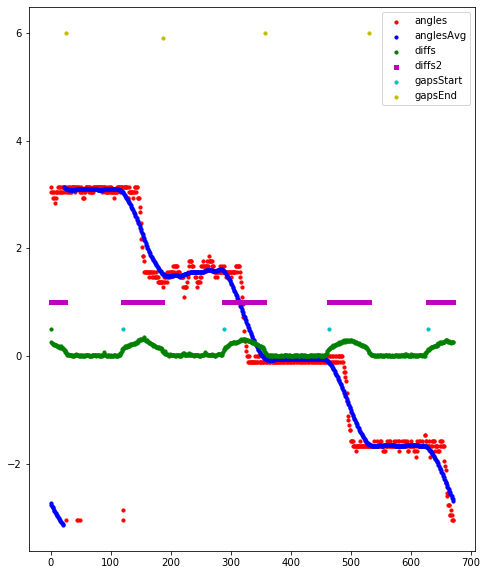

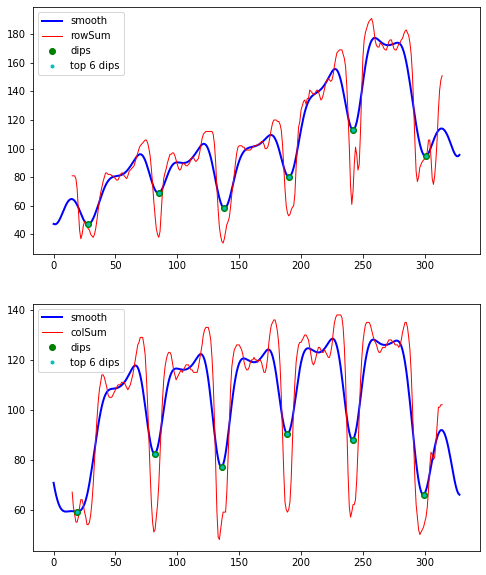

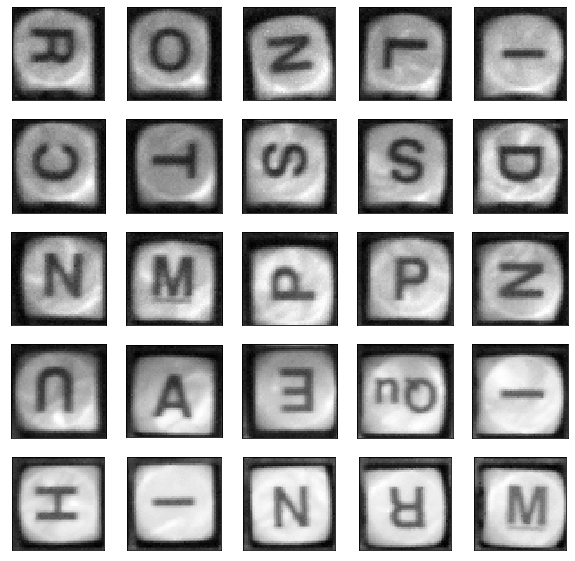

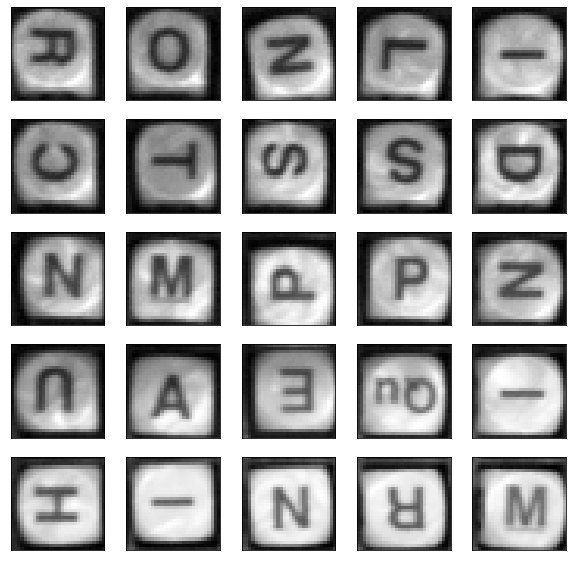

key 116
key 104
key 116
key 111
key 112
key 235
key 32
30


In [4]:
#process 1 image
letters5x5grid = findAndShowBoggleBoard(IMAGE_DIR, IMAGE_FILE)
print(len(letters5x5grid[0][0]))

In [5]:
#https://www.tensorflow.org/tutorials/keras/classification

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import json

#DATA_FILE="/home/johanv/downloads/labelled.json"
DATA_FILE="/home/johanv/nextcloud/projects/boggle2.0/labelled.json"
#DATA_FILE="/home/johanv/nextcloud/projects/boggle2.0/labelled-20200124_155523.mp4.json"

#import os
#DATA_FILE = "/labelled.json"
#DATA_URL = "https://drive.confuzer.cloud/index.php/s/2fQ5KkGi3Bi2SLq/download"
#os.system("curl " + DATA_URL + " > " + DATA_FILE)

MODEL_SAVE_FILE="/home/johanv/nextcloud/projects/boggle2.0/model.h5"

In [6]:
print(tf.__version__)

#fashion_mnist = keras.datasets.fashion_mnist
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

with open(DATA_FILE, 'r') as f:
    data = json.load(f)

IMG_DIM = 30

images_in = data["imgs"]
labels_in = data["labels"]

images = []
labels = []
for rot in range(4):
    for i in range(len(images_in)):
    #https://artemrudenko.wordpress.com/2014/08/28/python-rotate-2d-arraymatrix-90-degrees-one-liner/
        images_in[i] = list(zip(*images_in[i][::-1])) #rotate 90 degrees (still the same letter!)
    images.extend(images_in)
    labels.extend(labels_in)

2.4.1


In [7]:
images = np.array(images, dtype=np.uint8).reshape((-1, IMG_DIM, IMG_DIM, 1))

split = int(0.15 * len(images))

train_images = np.array(images[split:],dtype=np.uint8)
train_labels = np.array(labels[split:],dtype=np.uint8)

test_images = np.array(images[:split],dtype=np.uint8)
test_labels = np.array(labels[:split],dtype=np.uint8)

class_names = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

L = len(class_names)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

# plt.figure()
# plt.imshow(train_images[1])
# plt.colorbar()
# plt.grid(False)
# plt.show()

train_images = train_images / 255.0
test_images = test_images / 255.0


(443105, 30, 30, 1)
(443105,)
(78195, 30, 30, 1)
(78195,)


0/25
1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25


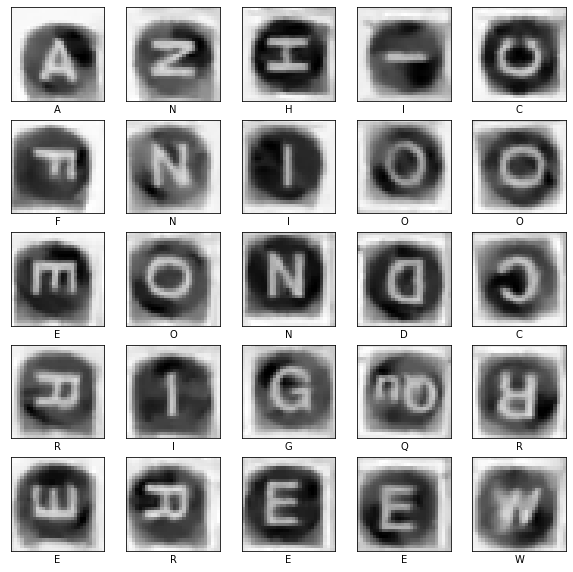

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    print("{}/25".format(i))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape((IMG_DIM, IMG_DIM)), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


In [9]:
model = tf.keras.models.load_model(MODEL_SAVE_FILE)

In [10]:
predictions = model.predict(test_images)
print("predictions[0]: ", predictions[0])
print("np.argmax(predictions[0]): ", np.argmax(predictions[0]))
print("test_labels[0]: ", test_labels[0])

predictions[0]:  [5.23892425e-07 5.42564638e-18 1.10985863e-14 3.16816755e-12
 3.35242341e-08 5.37046496e-09 2.87315495e-17 2.40110261e-08
 5.14411680e-10 1.35899995e-18 2.63122284e-11 1.25948505e-11
 5.07524751e-12 2.16679008e-10 3.83314088e-15 2.56593946e-08
 2.69415374e-23 9.99999404e-01 4.34893010e-08 5.56045574e-12
 4.07731357e-12 7.39448758e-13 1.56732655e-10 7.52348725e-26
 2.37690786e-26 7.36923625e-37]
np.argmax(predictions[0]):  17
test_labels[0]:  17


In [11]:
def get_label(predictions_array):
    predicted_label = np.argmax(predictions_array)
#     if class_names[predicted_label] == 'E' and 100*np.max(predictions_array) < 99.4:
#         predicted_label = class_names.index('Q')
#     if class_names[predicted_label] == 'T' and 100*np.max(predictions_array) < 96:
#         predicted_label = class_names.index('L')
#     if class_names[predicted_label] == 'U' and 100*np.max(predictions_array) < 67:
#         predicted_label = class_names.index('L')
#     if class_names[predicted_label] == 'R' and 100*np.max(predictions_array) < 85:
#         predicted_label = class_names.index('U')
    return predicted_label

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.reshape((IMG_DIM, IMG_DIM)), cmap=plt.cm.binary)

  predicted_label = get_label(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.2f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(L))
  plt.yticks([])
  thisplot = plt.bar(range(L), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = get_label(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

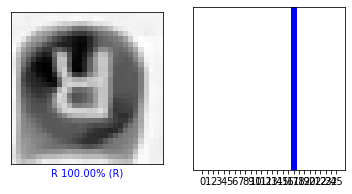

In [12]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

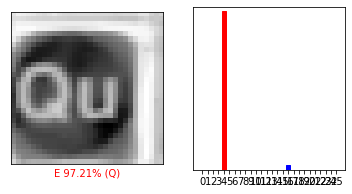

In [13]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

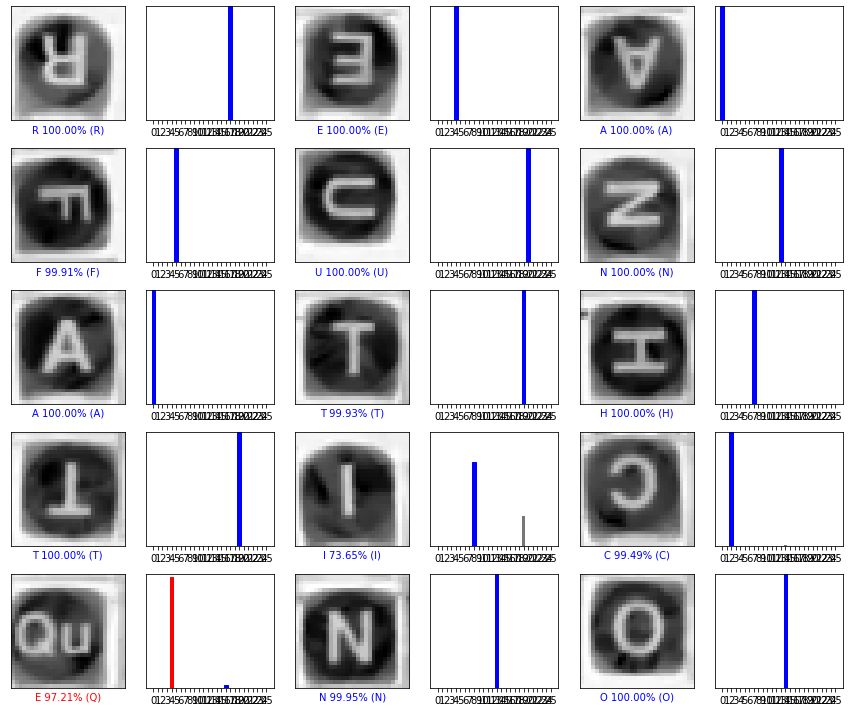

In [14]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
for j in range(1):
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i+j*num_images, predictions[i+j*num_images], test_labels, test_images)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i+j*num_images, predictions[i+j*num_images], test_labels)
    plt.tight_layout()
    plt.show()

(30, 30, 1)
(1, 30, 30, 1)
[[4.4070281e-15 1.0955106e-09 9.0535021e-16 3.4021423e-12 9.9999666e-01
  3.9170750e-12 4.1586319e-16 3.0104748e-06 8.1244365e-14 1.5609649e-25
  1.0513897e-25 5.1119719e-14 6.2850950e-15 4.1031254e-12 8.3552849e-16
  2.6532208e-13 3.7629418e-12 3.7549361e-07 3.4121174e-16 5.0614578e-12
  2.0608956e-16 3.1585216e-13 2.7860367e-16 1.2599848e-28 5.7528844e-33
  2.9854340e-18]]
np.argmax(predictions_single[0]):  4


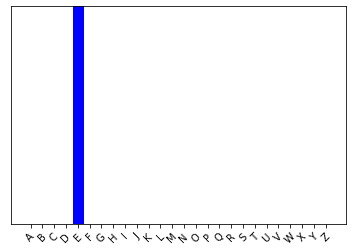

In [15]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

predictions_single = model.predict(img)

print(predictions_single)

plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(L), class_names, rotation=45)

print("np.argmax(predictions_single[0]): ", np.argmax(predictions_single[0]))

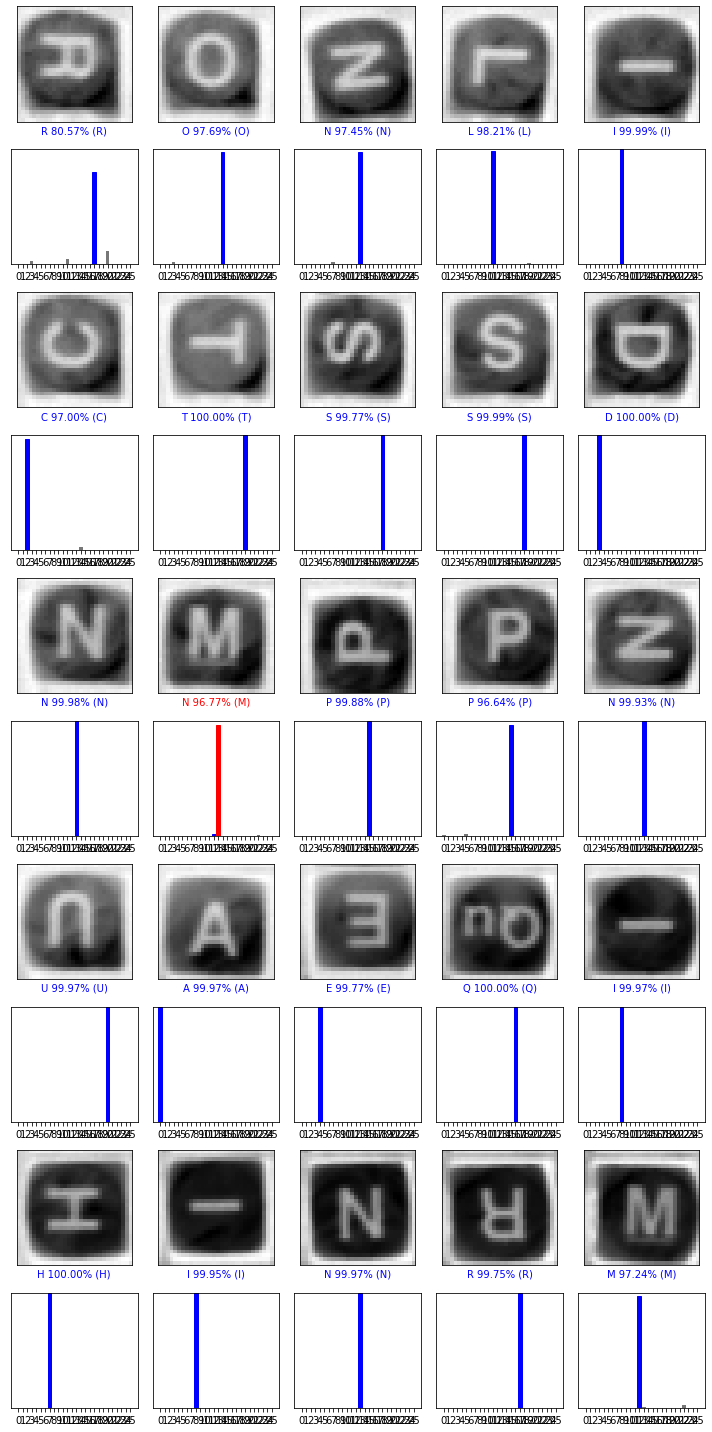

In [16]:
#show letters5x5grid
letters5x5gridFlat = []
for row in letters5x5grid:
    letters5x5gridFlat.extend(row)

    
letters5x5gridLabelsStr = "RONLICTSSDNMPPNUAEQIHINRM"
letters5x5gridLabels = [class_names.index(letter) for letter in letters5x5gridLabelsStr]

num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*2*num_rows))
for row in range(num_rows):
    for col in range(num_cols):
        letterImg = letters5x5grid[row][col]
        letterImg = letterImg / 255
    #     print(letterImg.shape)
        letterImg = (np.expand_dims(letterImg,0))
        letterImg = (np.expand_dims(letterImg,axis=3))

    #     print(letterImg.shape)
        pred = model.predict(letterImg)[0]
    #     print(np.argmax(pred))

        i = col+row*num_cols
        plt.subplot(2*num_rows, num_cols, col+2*row*num_cols+1)
        plot_image(i, pred, letters5x5gridLabels, letters5x5gridFlat)
        plt.subplot(2*num_rows, num_cols, col+2*row*num_cols+num_cols+1)
        plot_value_array(i, pred, letters5x5gridLabels)
plt.tight_layout()
plt.show()